# Setup

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rc = {
    "font.family": "sans",
    "font.size": 10,  
    "axes.axisbelow": True,
    "grid.linestyle": '--',
    "axes.grid": True,
    "mathtext.fontset": "cm",
}

plt.rcParams.update(rc)


In [16]:
from methods import secant, mod_secant 

# Data prep

In [17]:
q_values = pd.read_csv('./QVALUES.txt', sep='\s+', header=None, names=['i_ref', 'Q'])

q_values


,i_ref,Q
0,0.0,22.709
1,0.1,27.925
2,0.2,32.978
3,0.3,38.767
4,0.4,46.492
5,0.5,56.466
6,0.6,68.512
7,0.7,84.725
8,0.8,115.720
9,0.9,164.860


In [18]:
def q_func_polynomial(x, q_values=q_values, deg=6, q_drop=False):

    if q_drop:
        # drops Q-factor due to system indefinite oscilation
        q_values.loc[:, 'Q'][q_values['i_ref'] >= 0.9] = 20.0

    fit = np.polyfit(q_values['i_ref'], q_values['Q'], deg)
    poly = np.poly1d(fit)

    return poly




# Numerical methods

## Modified Secant

In [28]:
x0 = 0.1
x1 = 0.9
seek = 75
tol = 1e-3
MAX_ITER = 64

x = np.arange(0, 1, 1e-3)
f = q_func_polynomial(x, deg=12, q_drop=True)
y = f(x)

res_sec = secant(x0, x1, seek, tol, f, MAX_ITER, debug=True)
res_mod = mod_secant(x0, x1, seek, tol, f, MAX_ITER, debug=True)

print('Basic secant:\n', res_sec.loc[:, ['iter', 'x_next', 'f(x_next)', 'error']])
print()
print('Modified secant:\n', res_mod.loc[:, ['iter', 'x_next', 'f(x_next)', 'error']])


Basic secant:
    iter    x_next  f(x_next)     error
0     1  0.673034  78.744030 -3.744030
1     2  0.646310  74.341217  0.658783
2     3  0.650309  74.927379  0.072621
3     4  0.650804  75.001496 -0.001496
4     5  0.650794  74.999997  0.000003

Modified secant:
    iter    x_next  f(x_next)     error
0     1  0.684990  81.172214 -6.172214
1     2  0.643555  73.949092  1.050908
2     3  0.649583  74.819477  0.180523
3     4  0.650834  75.005939 -0.005939
4     5  0.650794  74.999967  0.000033


/tmp/ipykernel_6790/1604693170.py:8: RankWarning: Polyfit may be poorly conditioned
  f = q_func_polynomial(x, deg=12, q_drop=True)


In [20]:
res_mod

,iter,x0,x1,f(x0),f(x1),slope,x_next,f(x_next),error
0,1,0.000000,0.600000,22.709000,68.512000,76.338333,0.684990,81.172214,-6.172214
1,2,0.600000,0.684990,68.512000,81.172214,148.961105,0.643555,73.949092,1.050908
2,3,0.684990,0.643555,81.172214,73.949092,174.323878,0.649583,74.819477,0.180523
3,4,0.643555,0.649583,73.949092,74.819477,144.378856,0.650834,75.005939,-0.005939
4,5,0.649583,0.650834,74.819477,75.005939,149.128830,0.650794,74.999967,0.000033


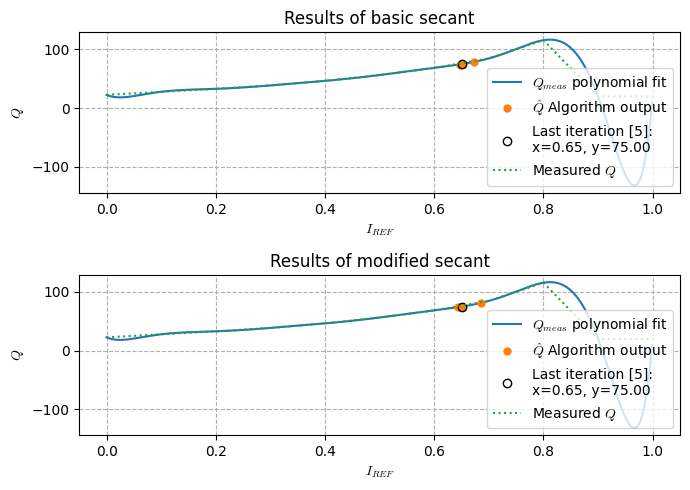

In [21]:
fig, ax = plt.subplots(nrows=2, figsize=(7,5))

ax[0].plot(x, y, label='$Q_{meas}$ polynomial fit')
ax[0].plot(res_sec['x_next'], res_sec['f(x_next)'], 'o',
           label='$\hat{Q}$ Algorithm output', markersize=5)

ax[1].plot(x, y, label='$Q_{meas}$ polynomial fit')
ax[1].plot(res_mod['x_next'], res_mod['f(x_next)'], 'o',
           label='$\hat{Q}$ Algorithm output', markersize=5)

q_x = res_sec.iloc[-1, 6]
q_y = res_sec.iloc[-1, 7]
last_iter = res_sec.iloc[-1, 0]

ax[0].plot(q_x, q_y, 'o',
           label=f'Last iteration [{last_iter}]:\nx={q_x:.2f}, y={q_y:.2f}', 
           c='k', fillstyle='none',)

ax[0].plot(q_values['i_ref'], q_values['Q'], ':', label='Measured $Q$')


q_x = res_mod.iloc[-1, 6]
q_y = res_mod.iloc[-1, 7]
last_iter = res_mod.iloc[-1, 0]

ax[1].plot(q_x, q_y, 'o',
           label=f'Last iteration [{last_iter}]:\nx={q_x:.2f}, y={q_y:.2f}',
           c='k', fillstyle='none',)

ax[1].plot(q_values['i_ref'], q_values['Q'], ':', label='Measured $Q$')

ax[0].set_title('Results of basic secant')
ax[1].set_title('Results of modified secant')

for ax in ax:
    ax.legend()
    ax.set(xlabel='$I_{REF}$', ylabel='$Q$')

fig.tight_layout()
plt.show()


In [22]:
x0 = 0.0
x1 = 1.0
multiple_seeks = np.arange(25, 300, 20)
tol = 10
MAX_ITER = 16

x = np.arange(0, 1, 1e-3)
f = q_func_polynomial(x)
y = f(x)

m_seeks_records = []
for seek in multiple_seeks:
  m_seeks_dict = dict()

  res_sec = secant(x0, x1, seek, tol, f, MAX_ITER, debug=True)
  m_seeks_dict['Method'] = 'basic'
  m_seeks_dict['Seek'] = seek
  m_seeks_dict['Iters-to-converge'] = res_sec['iter'].iat[-1]
  m_seeks_dict['x_next'] = res_sec['x_next'].iat[-1]
  m_seeks_dict['f(x_next)'] = res_sec['f(x_next)'].iat[-1]

  m_seeks_records.append(m_seeks_dict)

  m_seeks_dict = dict()

  res_mod = mod_secant(x0, x1, seek, tol, f, MAX_ITER, debug=True)
  m_seeks_dict['Method'] = 'modified'
  m_seeks_dict['Seek'] = seek
  m_seeks_dict['Iters-to-converge'] = res_mod['iter'].iat[-1]
  m_seeks_dict['x_next'] = res_mod['x_next'].iat[-1]
  m_seeks_dict['f(x_next)'] = res_mod['f(x_next)'].iat[-1]

  m_seeks_records.append(m_seeks_dict)

m_seeks_df = pd.DataFrame(m_seeks_records)
m_seeks_df.tail(4)


,Method,Seek,Iters-to-converge,x_next,f(x_next)
24,basic,265,12,1.098306,256.539662
25,modified,265,16,0.303689,42.380545
26,basic,285,13,1.104189,287.453697
27,modified,285,16,0.247582,43.820624


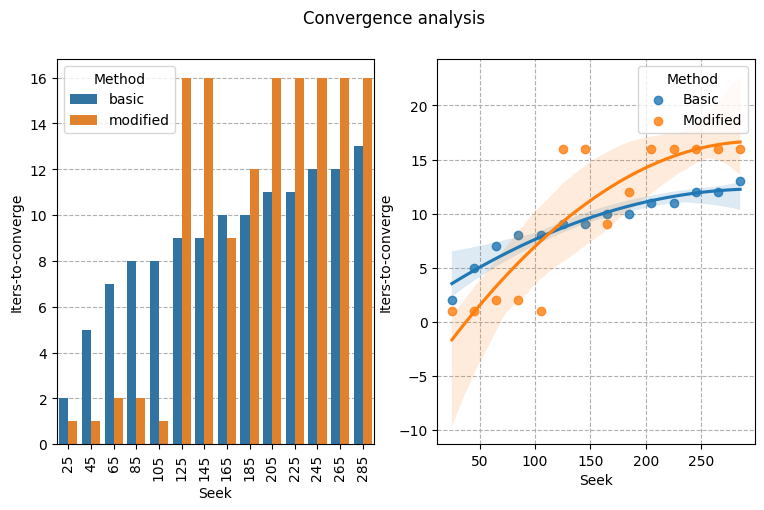

In [23]:
fig, ax = plt.subplots(figsize=(9, 5), ncols=2)

basic = m_seeks_df[m_seeks_df['Method'] == 'basic']
modif = m_seeks_df[m_seeks_df['Method'] == 'modified']

sns.barplot(data=m_seeks_df,
            y='Iters-to-converge',
            x='Seek',
            hue='Method',
            orient='v',
            ax=ax[0])

ax[0].set_xticklabels(rotation=90, labels=basic['Seek'])

sns.regplot(data=basic, x='Seek', y='Iters-to-converge', ax=ax[1], order=2, label='Basic')
sns.regplot(data=modif, x='Seek', y='Iters-to-converge', ax=ax[1], order=2, label='Modified')

ax[1].legend(title='Method')

fig.suptitle('Convergence analysis')


plt.show()

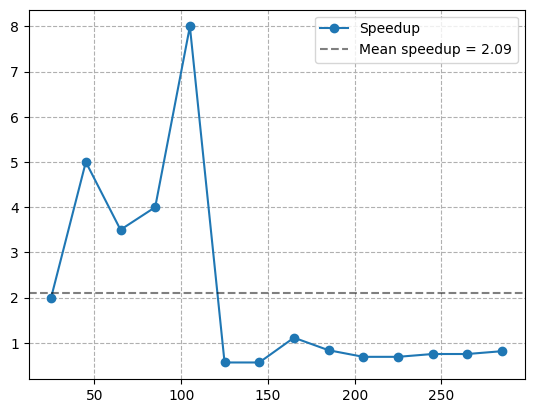

In [24]:


speedup = basic['Iters-to-converge'].values / modif['Iters-to-converge'].values

mean_speedup = np.mean(speedup)

plt.plot(basic['Seek'], speedup, '-o', label='Speedup')
plt.axhline(mean_speedup, ls='--', c='k', alpha=0.5, label=f'Mean speedup = {mean_speedup:.2f}')

plt.legend()
plt.show()

## Bisection

In [25]:
from methods import bisection


In [26]:
a = 0.7
b = 1.0
seek = 200
tol = 1
MAX_ITER = 64

x = np.arange(0, 1, 1e-3)
f = q_func_polynomial(x)
y = f(x)

res_bissection = bisection(a, b, seek, tol, f, MAX_ITER, debug=True)

res_bissection


,iter,a,b,c,f(a),f(b),f(c)
0,1,0.70000,1.0,0.850000,100.340549,16.986265,64.829992
1,2,0.85000,1.0,0.925000,64.829992,16.986265,21.754754
2,3,0.92500,1.0,0.962500,21.754754,16.986265,9.496680
3,4,0.96250,1.0,0.981250,9.496680,16.986265,9.928587
4,5,0.98125,1.0,0.990625,9.928587,16.986265,12.508775
...,...,...,...,...,...,...,...
59,60,1.00000,1.0,1.000000,16.986265,16.986265,16.986265
60,61,1.00000,1.0,1.000000,16.986265,16.986265,16.986265
61,62,1.00000,1.0,1.000000,16.986265,16.986265,16.986265
62,63,1.00000,1.0,1.000000,16.986265,16.986265,16.986265


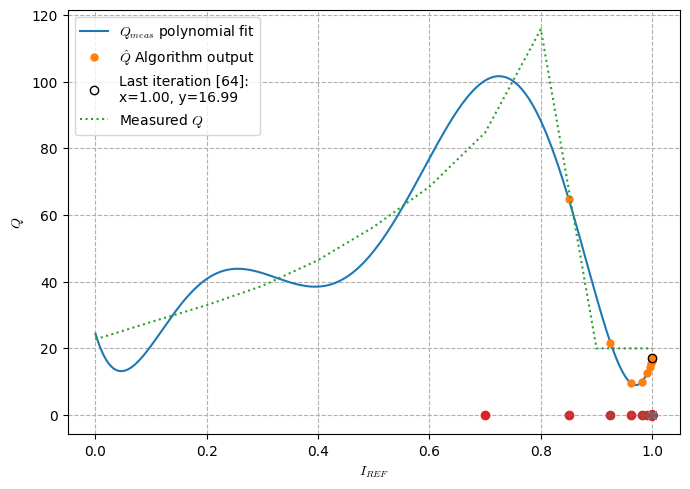

In [27]:
fig, ax = plt.subplots(nrows=1, figsize=(7, 5))

ax.plot(x, y, label='$Q_{meas}$ polynomial fit')
ax.plot(res_bissection['c'], res_bissection['f(c)'], 'o',
        label='$\hat{Q}$ Algorithm output', markersize=5)

q_x = res_bissection.iloc[-1, 3]
q_y = res_bissection.iloc[-1, -1]
last_iter = res_bissection.iloc[-1, 0]

ax.plot(q_x, q_y, 'o',
        label=f'Last iteration [{last_iter}]:\nx={q_x:.2f}, y={q_y:.2f}',
        c='k', fillstyle='none',)

ax.plot(q_values['i_ref'], q_values['Q'], ':', label='Measured $Q$')

ax.legend()
ax.set(xlabel='$I_{REF}$', ylabel='$Q$')


a = res_bissection['a']
b = res_bissection['b']
c = res_bissection['c']

ax.plot(a, np.zeros_like(a), 'o', b, np.zeros_like(b), 'x', c, np.zeros_like(c), '+')

fig.tight_layout()
plt.show()
